<a href="https://colab.research.google.com/github/jacksklar/pLLPRosetteDetector/blob/master/object_detection_DDN_5_13_19_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

#notes

the folders are in /content/ from root, for example os.chdir("/content/models/research") would be the full path


tutorials
https://medium.com/coinmonks/part-1-2-step-by-step-guide-to-data-preparation-for-transfer-learning-using-tensorflows-object-ac45a6035b7a
https://medium.com/coinmonks/modelling-transfer-learning-using-tensorflows-object-detection-model-on-mac-692c8609be40


for the later parts of the training
https://medium.com/swlh/how-to-train-an-object-detection-model-easy-for-free-f388ff3663e

other tutorials
https://3sidedcube.com/guide-retraining-object-detection-models-tensorflow/
https://medium.com/coinmonks/modelling-transfer-learning-using-tensorflows-object-detection-model-on-mac-692c8609be40

Learn about pre-trained models
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md



To edit files in colab

Unfortunately, it seems, colab do not support %load line magic (yet), and yet, you can see the file content using !cat your_file.py and then manually, copy the output contents, write them to a new cell and write %%writefile your_new_file_name.py at the top of the new cell to save this back to the instance. Note that, this will not be saved to your google drive yet.

Example:
!ls
output: colabData/

%%writefile something.py
print("everything's fine.")

!ls
output: colabData/ something.py

%run something.py
output: everything's fine.

In [0]:
pip install tensorflow-gpu



In [0]:
!pip install 'prompt-toolkit==1.0.15'

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!sudo apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib

In [0]:
#compile protobuf
import os
os.chdir('models/research')
!protoc object_detection/protos/*.proto --python_out=.


In [0]:

#run the setup script
os.getcwd()
!python3.6 setup.py build

In [0]:
#add libraries to python path
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

# Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile


from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [0]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Importing the labelled data from github

images and csv should be moved to a /data folder with the split and annotated images. 




In [0]:

#clone the repo including the data files and the py files into the models folder

os.chdir("/content/models/research/")


!rm -r pLLPRosetteDetector
!git clone https://github.com/jacksklar/pLLPRosetteDetector
  


Cloning into 'pLLPRosetteDetector'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 585 (delta 14), reused 0 (delta 0), pack-reused 556
Receiving objects: 100% (585/585), 18.82 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [0]:
#move the data directory from the cloned repo into the models directory, and remove the gdrive download above

!mv /content/models/research/pLLPRosetteDetector/data /content/models/research/data/


In [0]:
#copy generate_tf_record py to the models folder

!cp /content/models/research/pLLPRosetteDetector/generate_tfrecord.py /content/models/research/generate_tfrecord.py



In [0]:
#make the tf record

!python generate_tfrecord.py --csv_input=/content/models/research/data/train_labels.csv  --output_path=/content/models/research/train.record

!python generate_tfrecord.py --csv_input=/content/models/research/data/test_labels.csv  --output_path=/content/models/research/test.record

Successfully created the TFRecords: /content/models/research/train.record
Successfully created the TFRecords: /content/models/research/test.record


In [0]:
#check the file sizes for the record files

!ls -l train.record #7072246 
!ls -l test.record #1728388 

#total size is ~8.8MB, image files together are ~8.3MB, so looks good!



ls: cannot access 'train.record': No such file or directory
ls: cannot access 'test.record': No such file or directory


In [0]:
!ls

#Setting up to train a pre-existing model


In [0]:
#make a folder to put the record files in

os.chdir("/content/models/research/")

!mkdir rosette_detect
!mv train.record test.record rosette_detect


In [0]:
#Grab the ssd_movilenet_v1 model
!wget "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz"

#or the faster_rcnn_resetnet101_coco model
#http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz



In [0]:
#unzip the files

os.chdir("/content/models/research")
!ls

!tar -xvf ssd_mobilenet_v1_coco_2018_01_28.tar


In [0]:
#copy all the model files into the rosette_detect folder

!cp /content/models/research/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.* rosette_detect



In [0]:
os.chdir("/content/models/research/rosette_detect")

!ls

labelmap.pbtxt			model.ckpt.meta		      training
model.ckpt.data-00000-of-00001	ssd_mobilenet_v1_coco.config  train.record
model.ckpt.index		test.record


In [0]:
#make the label map

%%writefile labelmap.pbtxt 

item {
  id: 1
  name: 'nm'
}

Writing labelmap.pbtxt


In [0]:
#get the appropriate config file from the tensorflow models repository for the model we're using, edited from the cloned github repo


os.chdir("/content/models/research/rosette_detect")


!cp /content/models/research/pLLPRosetteDetector/ssd_mobilenet_v1_coco.config /content/models/research/rosette_detect
!ls




labelmap.pbtxt			model.ckpt.meta		      training
model.ckpt.data-00000-of-00001	ssd_mobilenet_v1_coco.config  train.record
model.ckpt.index		test.record


In [0]:
os.chdir("/content/models/research/rosette_detect")
!ls

labelmap.pbtxt			model.ckpt.meta		      training
model.ckpt.data-00000-of-00001	ssd_mobilenet_v1_coco.config  train.record
model.ckpt.index		test.record


In [0]:
# set up the model params

pipeline_fname = '/content/models/research/rosette_detect/ssd_mobilenet_v1_coco.config'



model_dir = '/content/models/research/rosette_detect/training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

num_steps = 1000
num_eval_steps = 50


In [0]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path='/content/models/research/rosette_detect/ssd_mobilenet_v1_coco.config' \
    --model_dir='training/' \
    --alsologtostderr \
    --num_train_steps=10000 \
    --num_eval_steps=50

In [0]:
#check the loss values -- this doesn't seem to work

os.chdir("/content/models/research/rosette_detect/training")
!ls

import tensorflow as tf
import re

for event in tf.train.summary_iterator("/content/models/research/rosette_detect/training/events.out.tfevents.1557766605.9fc9028d6d79"):
    for value in event.summary.value:
        if value.tag == "Losses/Loss/RPNLoss/objectness_loss":
            if value.HasField("simple_value"):
                print(value.simple_value)

In [0]:
os.chdir("/content/models/research/rosette_detect/training")

!ls
model_dir = "/content/models/research/rosette_detect/training"
#export the trained inference graph

import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}



checkpoint
eval_0
events.out.tfevents.1557766605.9fc9028d6d79
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta
model.ckpt-594.data-00000-of-00001
model.ckpt-594.index
model.ckpt-594.meta
/content/models/research/rosette_detect/training/model.ckpt-1000
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
111 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  1

In [0]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


In [0]:

#download the trained file

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
label_map_pbtxt_fname = '/content/models/research/rosette_detect/labelmap.pbtxt'

from google.colab import files
files.download(pb_fname)

In [0]:
os.chdir("/content/models/research/data")
!ls

In [0]:
#inference test

import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  "/content/models/research/pLLPRosetteDetector/test"

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/models/research/pLLPRosetteDetector/test/movie2_t10_z40.png', '/content/models/research/pLLPRosetteDetector/test/movie2_t53_z39.png', '/content/models/research/pLLPRosetteDetector/test/movie2_t5_z39.png', '/content/models/research/pLLPRosetteDetector/test/movie1_t76_z-1782.png', '/content/models/research/pLLPRosetteDetector/test/movie1_t92_z-1782.png', '/content/models/research/pLLPRosetteDetector/test/movie1_t116_z-1781.png', '/content/models/research/pLLPRosetteDetector/test/movie2_t33_z39.png', '/content/models/research/pLLPRosetteDetector/test/movie2_t63_z36.png', '/content/models/research/pLLPRosetteDetector/test/movie1_t54_z15.png', '/content/models/research/pLLPRosetteDetector/test/movie2_t68_z39.png']


In [0]:
os.chdir("/content/models/research/pLLPRosetteDetector/test")
!ls

plt.close(fig='all')

movie1_t116_z-1781.png	movie2_t10_z40.png  movie2_t63_z36.png
movie1_t54_z15.png	movie2_t33_z39.png  movie2_t68_z39.png
movie1_t76_z-1782.png	movie2_t53_z39.png
movie1_t92_z-1782.png	movie2_t5_z39.png


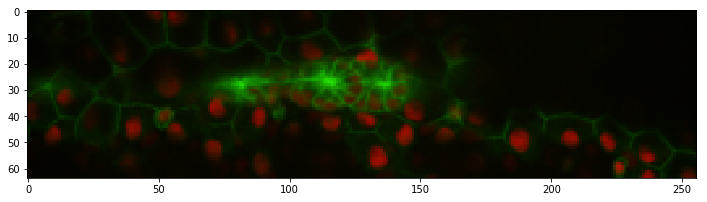

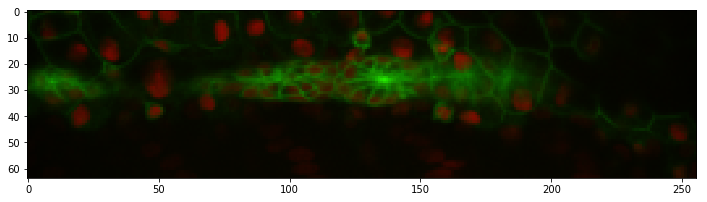

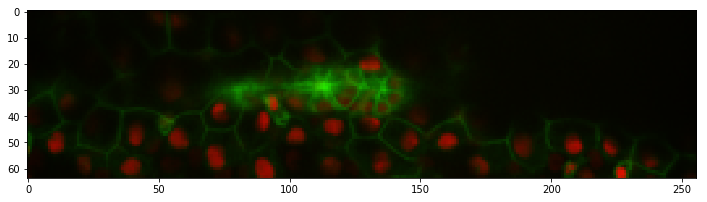

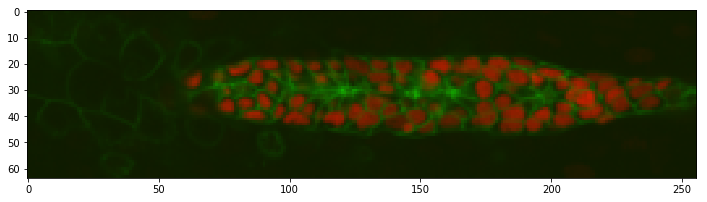

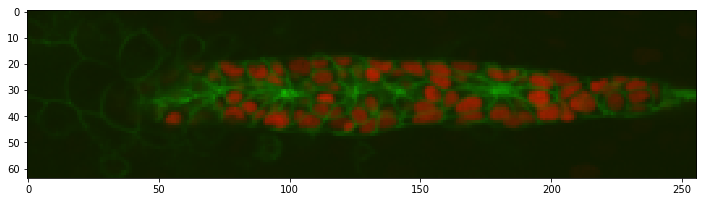

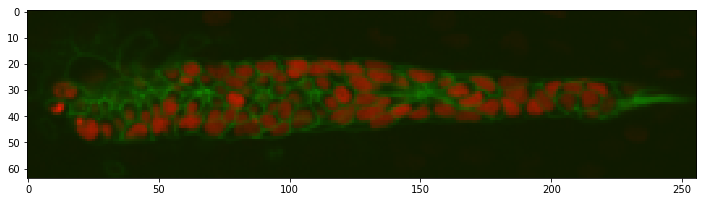

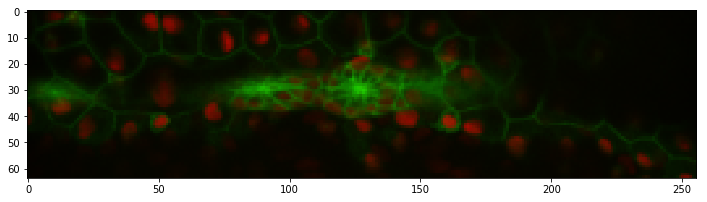

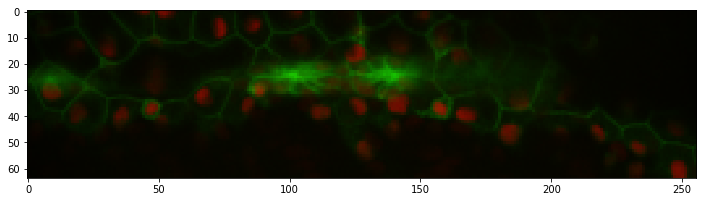

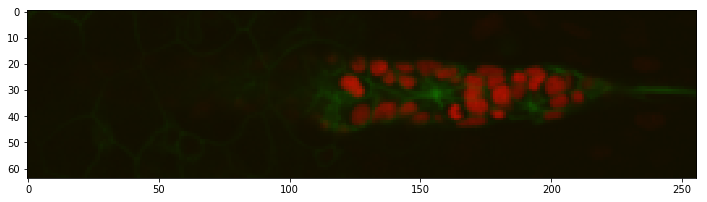

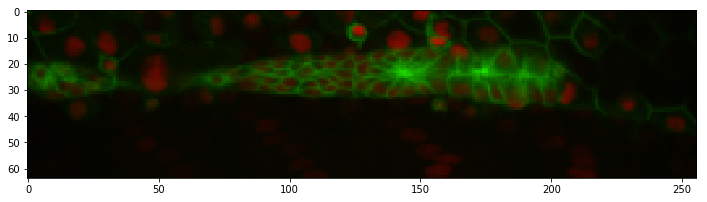

In [0]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

num_classes = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict
    

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    #print(output_dict)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)